____
__Universidad de San Andrés__<br/>
__Machine Learning__<br/>
__Detección de ballenas__<br/>
__Martin Bianchi y Federico Gutman__
____

### Importamos las librerías necesarias

In [111]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import librosa
from IPython.display import Audio, display

from torch.utils.data import TensorDataset, DataLoader
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA 

### NOTAS
- ver repo para preprocesar espectrogrma
    - ver de reducir el y-lim del spectrograma -> averiguar bien entre que frecuencias se mueven los cantos de ballena
- cambiar noise a no right whale
- cambiar el idioma a español


### Definimos algunas variables globales

In [122]:
SEED = 3            # semilla para reproductibilidad
SR = 2000           # sampling rate
N_FFT = 256         # tamaño de la ventana
HOP_LENGTH = 64     # salto entre frames
N_MELS = 50         # frequency bins (resolución)
MAX_FREQ = 600      # máxima frecuencia para los espectrogramas --ponerlo en 500--

### Cargamos los datos y los visualizamos

In [128]:
def load_data(train_path:str, test_path:str, labels_path:str, sampling_rate=SR):
    test_files = [f for f in os.listdir(test_path) if f.endswith('.aiff')]
    labels_df = pd.read_csv(labels_path)

    audio_df = labels_df.copy()
    audio_df['filepath'] = audio_df['clip_name'].apply(lambda x: os.path.join(train_path, x))
    audio_df['audio'] = audio_df['filepath'].apply(lambda path: librosa.load(path, sr=sampling_rate)[0])

    return audio_df, labels_df, test_files

def display_random_samples(dataset:pd.DataFrame, sampling_rate=SR):
    np.random.seed(SEED)

    # SAMPLES
    whale_sample = dataset[dataset['label'] == 1].sample(5)['audio']
    noise_sample = dataset[dataset['label'] == 0].sample(5)['audio']

    # AUDIO
    print('right whale call random audio sample')
    display(Audio(np.array(whale_sample.iloc[0]), rate=sampling_rate*1.5))
    print('\nno whale random audio sample')
    display(Audio(np.array(noise_sample.iloc[0]), rate=sampling_rate*1.5))

    # SOUND-WAVE
    fig, axes = plt.subplots(2, 5, figsize=(15, 5))

    for i in range(5):
        axes[0, i].plot(np.array(whale_sample.iloc[i]))
        axes[0, i].set_title('Whale')
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])

        axes[1, i].plot(np.array(noise_sample.iloc[i]), color='#FF6961')
        axes[1, i].set_title('No Whale')
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])

    plt.tight_layout()
    plt.show()

    # MULTIPLE SPECTROGRAMS
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for i in range(5):
        whale_sample_spectrogram = get_melspectrogram(whale_sample.iloc[i])
        img0 = librosa.display.specshow(whale_sample_spectrogram, sr=sampling_rate, hop_length=HOP_LENGTH, ax=axes[0, i], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
        axes[0, i].set_title('Whale')
        axes[0, i].set_ylim([0, MAX_FREQ])
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])
        axes[0, i].set_xlabel('')
        axes[0, i].set_ylabel('')

        noise_sample_spectrogram = get_melspectrogram(noise_sample.iloc[i])
        img1 = librosa.display.specshow(noise_sample_spectrogram, sr=sampling_rate, hop_length=HOP_LENGTH, ax=axes[1, i], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
        axes[1, i].set_title('No Whale')
        axes[1, i].set_ylim([0, MAX_FREQ])
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])
        axes[1, i].set_xlabel('')
        axes[1, i].set_ylabel('')

    plt.tight_layout()
    plt.show()

    # TWO SPECTROGRAMS
    whale_sample2 = dataset[dataset['label'] == 1].sample(1, random_state=SEED+1)['audio']
    noise_sample2 = dataset[dataset['label'] == 0].sample(1, random_state=SEED+1)['audio']
    
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))

    whale_sample2_spectrogram = get_melspectrogram(whale_sample2.iloc[0])
    img0 = librosa.display.specshow(whale_sample2_spectrogram, sr=sampling_rate, hop_length=HOP_LENGTH, ax=axes[0], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
    axes[0].set_title('Whale')
    axes[0].set_ylim([0, MAX_FREQ])
    fig.colorbar(img0, ax=axes[0], format="%+2.0f dB")

    noise_sample2_spectrogram = get_melspectrogram(noise_sample2.iloc[0])
    img1 = librosa.display.specshow(noise_sample2_spectrogram, sr=sampling_rate, hop_length=HOP_LENGTH, ax=axes[1], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
    axes[1].set_title('No Whale')
    axes[1].set_ylim([0, MAX_FREQ])
    fig.colorbar(img1, ax=axes[1], format="%+2.0f dB")

    plt.tight_layout()
    plt.show()

def normalize(dataset:pd.DataFrame, column:str):
    dataset[column] = dataset[column].apply(lambda x: x / np.max(np.abs(x)))

def get_signal_energy(dataset:pd.DataFrame, column:str):
    energy = []
    df = dataset.copy()
    for x in df[column]:
        energy.append(np.sum(np.square(x)))
    df['energy'] = energy

    return df

def get_melspectrogram(sample:pd.DataFrame, sampling_rate=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    mel_spectrogram = librosa.feature.melspectrogram(y=np.array(sample), sr=sampling_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=MAX_FREQ)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram

def get_all_mel_spectrograms(audio_df, sampling_rate=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    mel_specs = []
    for audio in audio_df['audio']:
        mel = get_melspectrogram(audio, sampling_rate, n_fft, hop_length, n_mels)
        mel_specs.append(mel.flatten())
    return np.array(mel_specs)

def show_class_balance(dataset:pd.DataFrame):
    plt.figure(figsize=(5, 4))
    ax = sns.countplot(
        x='label',
        data=dataset,
        palette={0: '#FF6961', 1: plt.rcParams['axes.prop_cycle'].by_key()['color'][0]},
        hue='label',
        legend=False
    )
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Noise', 'Whale'])
    ax.legend(['Noise', 'Whale'], title='Class')
    plt.show()

def extract_time_acoustic_features(dataset:pd.DataFrame):
    new_features = []
    for audio in dataset['audio']:
        audio_np = np.array(audio)
        acoustic_features = {
            'rms_energy': np.mean(librosa.feature.rms(y=audio_np)),
            'zcr': np.mean(librosa.feature.zero_crossing_rate(y=audio_np)),
        }
        new_features.append(acoustic_features)
    features_df = pd.DataFrame(new_features)
    return features_df

def extract_frequency_acoustic_features(dataset:pd.DataFrame):
    new_features = []
    for audio in dataset['audio']:
        audio_np = np.array(audio)
        acoustic_features = {
            'spectral_centroid': np.mean(librosa.feature.spectral_centroid(y=audio_np)),
            'spectral_bandwidth': np.mean(librosa.feature.spectral_bandwidth(y=audio_np)),
            'spectral_rolloff': np.mean(librosa.feature.spectral_rolloff(y=audio_np)),
            'spectral_flatness': np.mean(librosa.feature.spectral_flatness(y=audio_np))
        }
        new_features.append(acoustic_features)
    features_df = pd.DataFrame(new_features)
    return features_df

def extract_acoustic_features(dataset:pd.DataFrame):
    time_features = extract_time_acoustic_features(dataset)
    frequency_features = extract_frequency_acoustic_features(dataset)

    new_df = pd.concat([dataset.reset_index(drop=True), time_features], axis=1)
    new_df = pd.concat([new_df.reset_index(drop=True), frequency_features], axis=1)
    
    return new_df

def display_features_boxplots(audio_features_df:pd.DataFrame):
    time_features = ['rms_energy', 'zcr']
    freq_features = ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'spectral_flatness']

    # TIME
    fig, axes = plt.subplots(1, len(time_features), figsize=(5 * len(time_features), 5))
    if len(time_features) == 1:
        axes = [axes]
    for i, feature in enumerate(time_features):
        sns.boxplot(x='label', y=feature, data=audio_features_df, ax=axes[i], showfliers=False)
        axes[i].set_title(f'{feature} by Class')
        axes[i].set_xlabel('Class')
        axes[i].set_xticks([0, 1])
        axes[i].set_xticklabels(['Noise', 'Whale'])

    plt.suptitle('Time Domain Features by Class')
    plt.tight_layout()
    plt.show()

    # FREQUENCY
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()
    for i, feature in enumerate(freq_features):
        sns.boxplot(x='label', y=feature, data=audio_features_df, ax=axes[i], showfliers=False)
        axes[i].set_title(f'{feature} by Class')
        axes[i].set_xlabel('Class')
        axes[i].set_xticks([0, 1])
        axes[i].set_xticklabels(['Noise', 'Whale'])

    plt.suptitle('Frequency Domain Features by Class')
    plt.tight_layout()
    plt.show()

def plot_pca(dataset:pd.DataFrame, pca_arr):
    plt.figure(figsize=(8,6))
    scatter = sns.scatterplot(
        x=pca_arr[:,0], 
        y=pca_arr[:,1], 
        hue=dataset['label'], 
        palette={0: '#FF6961', 1: '#1f77b4'}
    )
    plt.title('PCA of Mel Spectrograms')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    # Fix legend labels and colors
    handles, _ = scatter.get_legend_handles_labels()
    scatter.legend(handles=handles, title='Class', labels=['Noise', 'Whale'])
    plt.show()

def plot_average_spectrograms(audio_df:pd.DataFrame):
    whale_spectrograms = []
    noise_spectrograms = []
    for audio, label in zip(audio_df['audio'], audio_df['label']):
        spectrogram = get_melspectrogram(audio)
        if label == 1:
            whale_spectrograms.append(spectrogram)
        else: 
            noise_spectrograms.append(spectrogram)
    
    whale_spectrograms = np.array(whale_spectrograms)
    noise_spectrograms = np.array(noise_spectrograms)

    whale_average_spectrogram = whale_spectrograms.mean(axis=0)
    noise_average_spectrogram = noise_spectrograms.mean(axis=0)
    average_differences_spectrogram = whale_average_spectrogram - noise_average_spectrogram

    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    img0 = librosa.display.specshow(whale_average_spectrogram, sr=SR, hop_length=HOP_LENGTH, ax=axes[0], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
    axes[0].set_title('Whale Call Average Spectrogram', pad=20)
    axes[0].set_ylim([0, MAX_FREQ])
    # axes[0].set_xticks([])
    # axes[0].set_yticks([])
    fig.colorbar(img0, ax=axes[0], format="%+2.0f dB")

    img1 = librosa.display.specshow(noise_average_spectrogram, sr=SR, hop_length=HOP_LENGTH, ax=axes[1], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
    axes[1].set_title('No Whale Call Average Spectrogram', pad=20)
    axes[1].set_ylim([0, MAX_FREQ])
    # axes[1].set_xticks([])
    # axes[1].set_yticks([])
    fig.colorbar(img1, ax=axes[1], format="%+2.0f dB")

    img2 = librosa.display.specshow(average_differences_spectrogram, sr=SR, hop_length=HOP_LENGTH, ax=axes[2], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
    axes[2].set_title('Average Differences Spectrogram', pad=20)
    axes[2].set_ylim([0, MAX_FREQ])
    # axes[2].set_xticks([])
    # axes[2].set_yticks([])
    fig.colorbar(img2, ax=axes[2], format="%+2.0f dB")

    # 3 subplots -> average spectrogram whale, noise, resto y consigo diferencias
    plt.tight_layout()
    plt.show()

def normalize_spectrogram(spec, global_min, global_max):
    norm_spec = (spec - global_min) / (global_max - global_min + 1e-8)
    return norm_spec

def denormalize_spectrogram(norm_spec, min_val, max_val):
    return norm_spec * (max_val - min_val + 1e-8) + min_val

def compute_global_min_max(audio_df):
    whale_specs = [get_melspectrogram(audio) for audio, label in zip(audio_df['audio'], audio_df['label']) if label == 1]
    global_min = np.min([spec.min() for spec in whale_specs])
    global_max = np.max([spec.max() for spec in whale_specs])
    return global_min, global_max


In [100]:
train_dir = 'data/whale-detection-challenge/data/train'
test_dir = 'data/whale-detection-challenge/data/test'
labels_dir = 'data/whale-detection-challenge/data/train.csv'

audio_df, labels_df, test_files = load_data(train_dir, test_dir, labels_dir)

right whale call random audio sample



no whale random audio sample


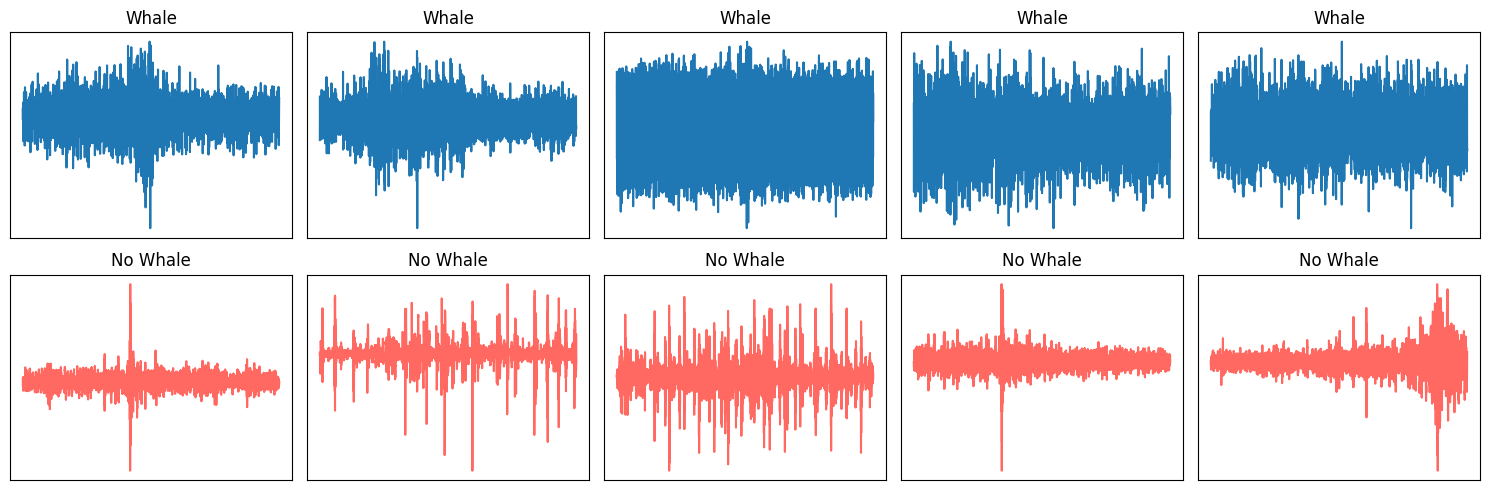

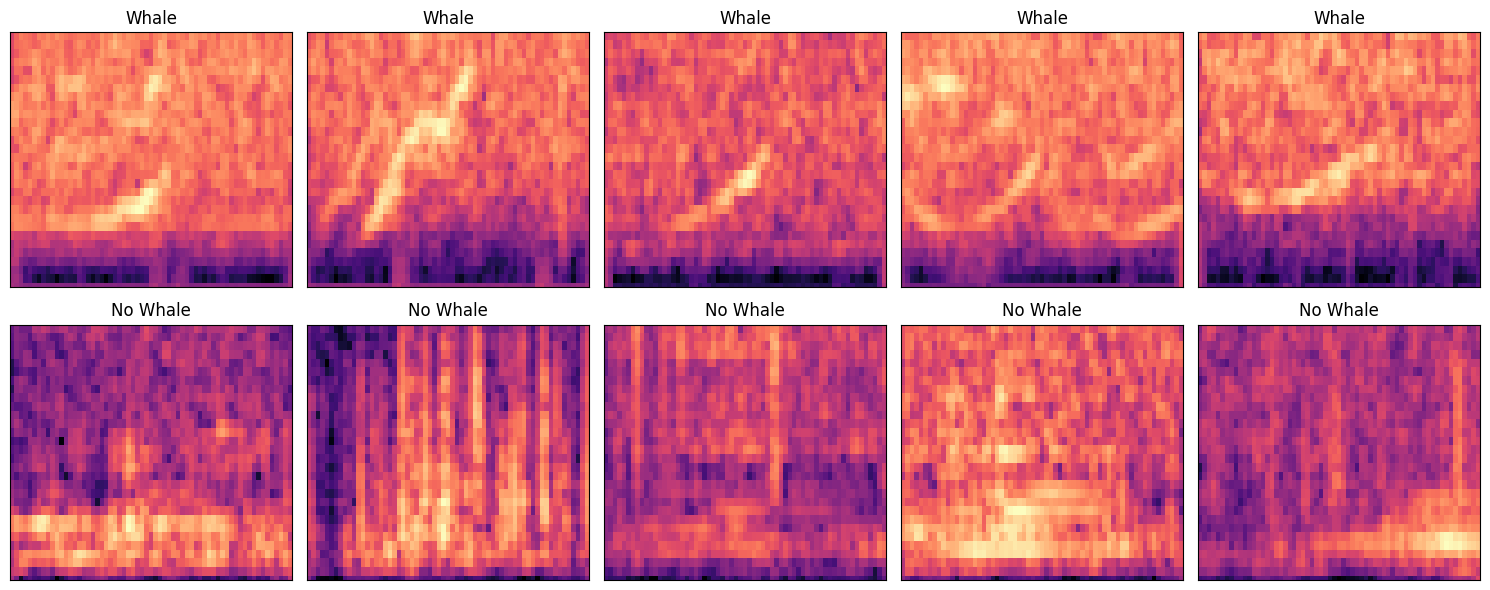

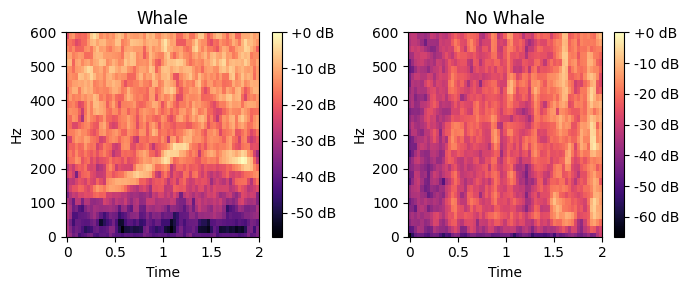

In [129]:
normalize(audio_df, 'audio')
display_random_samples(audio_df)

### Hacemos un análisis exploratorio de los datos

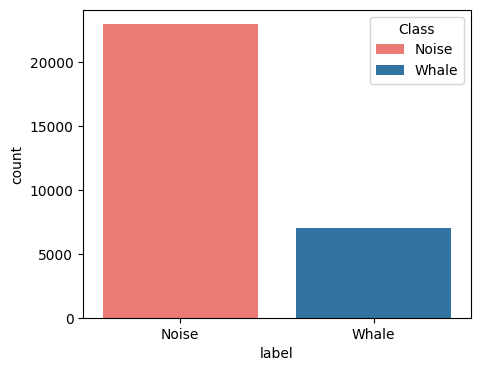

In [108]:
show_class_balance(audio_df)

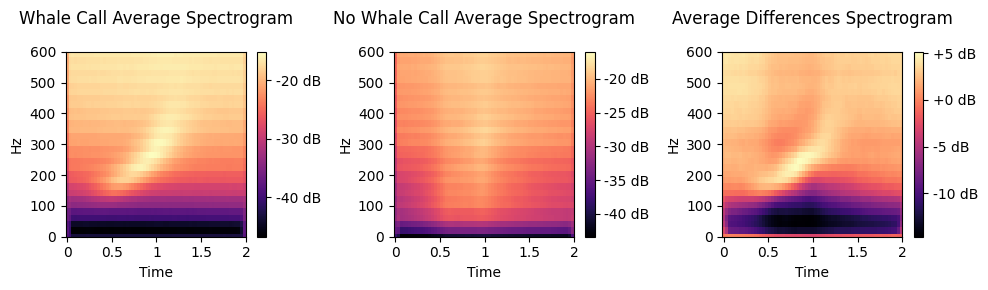

In [130]:
plot_average_spectrograms(audio_df)

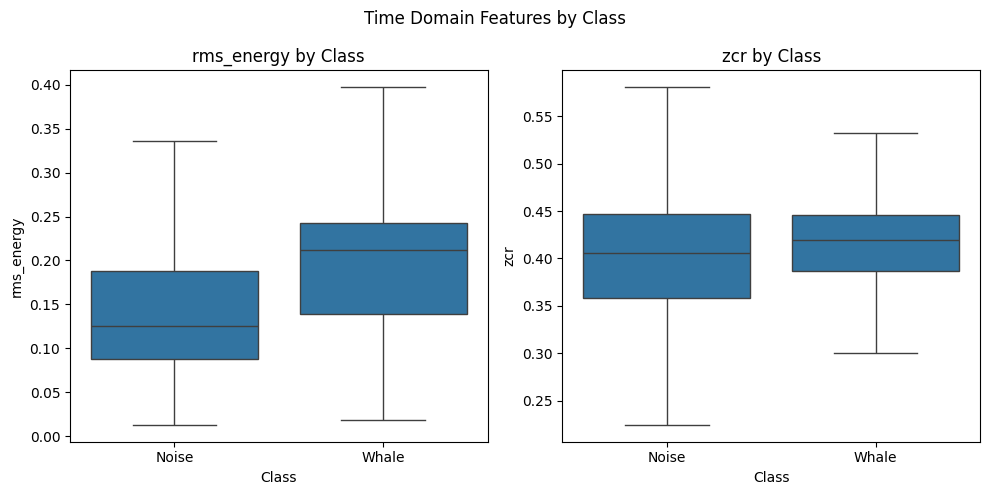

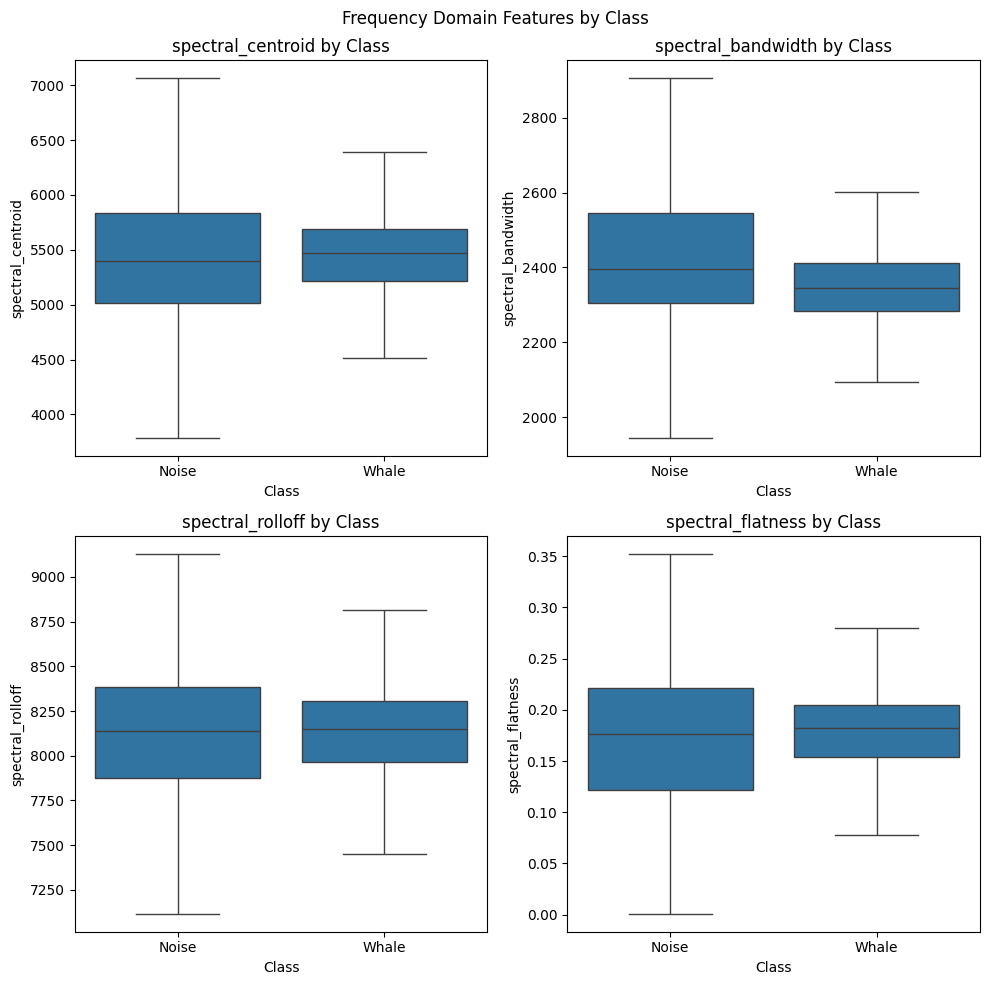

In [15]:
audio_features_df = extract_acoustic_features(audio_df)
display_features_boxplots(audio_features_df)

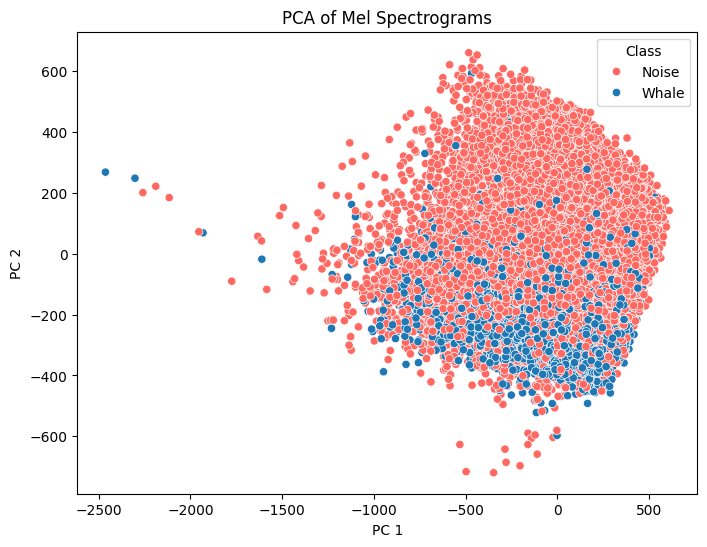

In [16]:
# PCA
flattened_mel_spectrogram = get_all_mel_spectrograms(audio_df)
pca = PCA(n_components=2)
spec_pca = pca.fit_transform(flattened_mel_spectrogram)

plot_pca(audio_df, spec_pca)

### Entrenamos un clasificador

### Busqueda de preproc
Vemos un poco q onda antes, probamos weight y max_freq

In [21]:
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score

audio_train_df = audio_df[audio_df['clip_name'].str.contains('train')]

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        return self.model(x)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_class_weights(y):
    weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    return torch.tensor(weights, dtype=torch.float32)

for mf in [500, 600, 1000]:
    print(f"\n====== max_freq = {mf} Hz ======")
    MAX_FREQ = mf
    X = get_all_mel_spectrograms(audio_train_df)
    y = audio_train_df['label'].values
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=128)

    for weighted in [False, True]:
        print(f"\n--- Weighted = {weighted} ---")
        
        # MLP con early stopping
        mlp = MLP(X_train.shape[1]).to(device)
        if weighted:
            weights = get_class_weights(y_train).to(device)
            criterion = nn.CrossEntropyLoss(weight=weights)
        else:
            criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(mlp.parameters(), lr=1e-3)

        best_auc = 0
        patience = 3
        counter = 0

        for epoch in range(20):
            mlp.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                loss = criterion(mlp(xb), yb)
                loss.backward()
                optimizer.step()

            mlp.eval()
            all_probs, all_targets = [], []
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb = xb.to(device)
                    probs = torch.softmax(mlp(xb), dim=1)[:, 1].cpu().numpy()
                    all_probs.extend(probs)
                    all_targets.extend(yb.numpy())
            auc = roc_auc_score(all_targets, all_probs)
            print(f"Epoch {epoch+1} - AUC: {auc:.4f}")

            if auc > best_auc:
                best_auc = auc
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print("Early stopping")
                    break

        print(f"AUC MLP final: {best_auc:.4f}")
        
        y_pred = [1 if p > 0.5 else 0 for p in all_probs]
        f1 = f1_score(all_targets, y_pred)
        print(f"F1-SCORE: {f1:.4f}")


====== max_freq = 500 Hz ======

--- Weighted = False ---
Epoch 1 - AUC: 0.9038
Epoch 2 - AUC: 0.9182
Epoch 3 - AUC: 0.9248
Epoch 4 - AUC: 0.9252
Epoch 5 - AUC: 0.9279
Epoch 6 - AUC: 0.9338
Epoch 7 - AUC: 0.9372
Epoch 8 - AUC: 0.9361
Epoch 9 - AUC: 0.9324
Epoch 10 - AUC: 0.9407
Epoch 11 - AUC: 0.9372
Epoch 12 - AUC: 0.9340
Epoch 13 - AUC: 0.9437
Epoch 14 - AUC: 0.9392
Epoch 15 - AUC: 0.9392
Epoch 16 - AUC: 0.9443
Epoch 17 - AUC: 0.9441
Epoch 18 - AUC: 0.9444
Epoch 19 - AUC: 0.9411
Epoch 20 - AUC: 0.9437
AUC MLP final: 0.9444
F1-SCORE: 0.7619

--- Weighted = True ---
Epoch 1 - AUC: 0.8996
Epoch 2 - AUC: 0.9194
Epoch 3 - AUC: 0.9242
Epoch 4 - AUC: 0.9297
Epoch 5 - AUC: 0.9317
Epoch 6 - AUC: 0.9282
Epoch 7 - AUC: 0.9361
Epoch 8 - AUC: 0.9376
Epoch 9 - AUC: 0.9357
Epoch 10 - AUC: 0.9373
Epoch 11 - AUC: 0.9356
Early stopping
AUC MLP final: 0.9376
F1-SCORE: 0.7421

====== max_freq = 600 Hz ======

--- Weighted = False ---
Epoch 1 - AUC: 0.9023
Epoch 2 - AUC: 0.9188
Epoch 3 - AUC: 0.9211
Epo

### Ahora q tenemos preprocesamos
weight y maxfreq no cambio casi nada, habria q entender pq 

In [22]:
# --------------------------
# Preprocesamiento
# --------------------------
# SEPARAMOS EN TRAIN Y TEST
audio_train_df = audio_df[audio_df['clip_name'].str.contains('train')]
X = get_all_mel_spectrograms(audio_train_df)
y = audio_train_df['label'].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create DataLoaders
batch_size = 128
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)

### Entrenamos 3 clasif


In [ ]:
MAX_FREQ = 600

# --------------------------
# MLP (PyTorch)
# --------------------------
mlp_torch = MLP(X_train.shape[1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_torch.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_torch.parameters(), lr=1e-3)

epochs = 20
for epoch in range(epochs):
    mlp_torch.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = mlp_torch(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    avg_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    mlp_torch.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = mlp_torch(xb)
            _, predicted = torch.max(outputs, 1)
            total += yb.size(0)
            correct += (predicted == yb).sum().item()
    val_acc = correct / total
    print(f"Validation Accuracy (MLP): {val_acc:.4f}")

# --------------------------
# Random Forest
# --------------------------
def train_random_forest(X_train, y_train, X_val, y_val):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_val)
    acc = accuracy_score(y_val, preds)
    print(f"Validation Accuracy (Random Forest): {acc:.4f}")
    return rf

# --------------------------
# Gradient Boosting
# --------------------------
def train_gradient_boosting(X_train, y_train, X_val, y_val):
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
    gb.fit(X_train, y_train)
    preds = gb.predict(X_val)
    acc = accuracy_score(y_val, preds)
    print(f"Validation Accuracy (Gradient Boosting): {acc:.4f}")
    return gb

# --------------------------
# Ejecutar modelos sklearn
# --------------------------
# Convertimos a numpy si venís usando tensores
X_train_np = X_train_tensor.numpy()
y_train_np = y_train_tensor.numpy()
X_val_np = X_val_tensor.numpy()
y_val_np = y_val_tensor.numpy()

rf_model = train_random_forest(X_train_np, y_train_np, X_val_np, y_val_np)
gb_model = train_gradient_boosting(X_train_np, y_train_np, X_val_np, y_val_np)


Epoch 1/20 - Loss: 0.4686
Validation Accuracy (MLP): 0.8245
Epoch 2/20 - Loss: 0.3332
Validation Accuracy (MLP): 0.8440
Epoch 3/20 - Loss: 0.2961
Validation Accuracy (MLP): 0.8680
Epoch 4/20 - Loss: 0.2858
Validation Accuracy (MLP): 0.8607
Epoch 5/20 - Loss: 0.2914
Validation Accuracy (MLP): 0.8593
Epoch 6/20 - Loss: 0.2777
Validation Accuracy (MLP): 0.8730
Epoch 7/20 - Loss: 0.2700
Validation Accuracy (MLP): 0.8652
Epoch 8/20 - Loss: 0.2742
Validation Accuracy (MLP): 0.8747
Epoch 9/20 - Loss: 0.2596
Validation Accuracy (MLP): 0.8730
Epoch 10/20 - Loss: 0.2556
Validation Accuracy (MLP): 0.8702
Epoch 11/20 - Loss: 0.2601
Validation Accuracy (MLP): 0.8775
Epoch 12/20 - Loss: 0.2581
Validation Accuracy (MLP): 0.8715
Epoch 13/20 - Loss: 0.2468
Validation Accuracy (MLP): 0.8847
Epoch 14/20 - Loss: 0.2530
Validation Accuracy (MLP): 0.8678
Epoch 15/20 - Loss: 0.2501
Validation Accuracy (MLP): 0.8815
Epoch 16/20 - Loss: 0.2441
Validation Accuracy (MLP): 0.8873
Epoch 17/20 - Loss: 0.2453
Valida

### Visualizamos

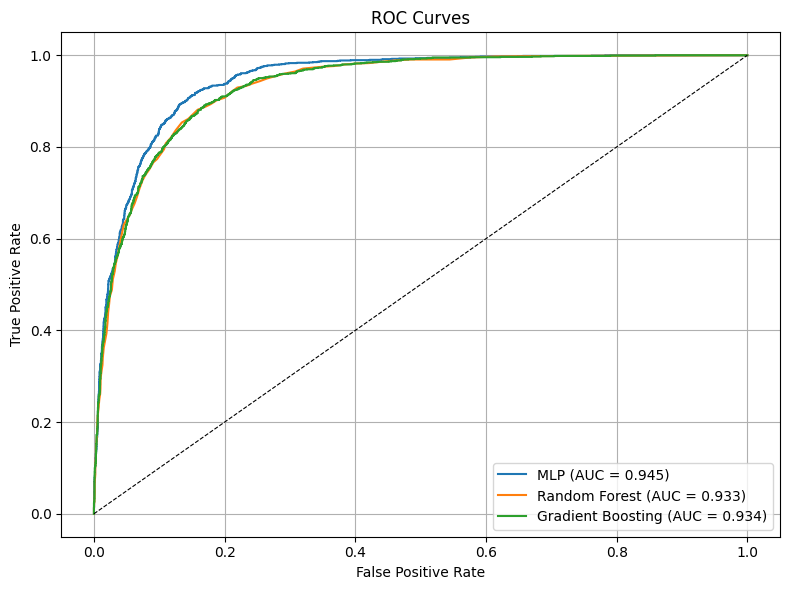

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import torch.nn.functional as F

# Asegurate de que y_val_np esté definido
# (ya lo tenés si ejecutaste los bloques anteriores)
# y que las etiquetas estén en formato binario (0/1)

# 1. MLP - predicción de probabilidades
mlp_torch.eval()
mlp_probs = []
with torch.no_grad():
    for xb, _ in val_loader:
        xb = xb.to(device)
        outputs = mlp_torch(xb)
        probs = F.softmax(outputs, dim=1)[:, 1]  # clase positiva
        mlp_probs.extend(probs.cpu().numpy())
mlp_probs = np.array(mlp_probs)
mlp_auc = roc_auc_score(y_val_np, mlp_probs)
fpr_mlp, tpr_mlp, _ = roc_curve(y_val_np, mlp_probs)

# 2. Random Forest
rf_probs = rf_model.predict_proba(X_val_np)[:, 1]
rf_auc = roc_auc_score(y_val_np, rf_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_val_np, rf_probs)

# 3. Gradient Boosting
gb_probs = gb_model.predict_proba(X_val_np)[:, 1]
gb_auc = roc_auc_score(y_val_np, gb_probs)
fpr_gb, tpr_gb, _ = roc_curve(y_val_np, gb_probs)

# 4. Plot all ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {mlp_auc:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.3f})')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {gb_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Entrenamos modelos generativos

#### Variational Autoencoder (VAE)

             clip_name  ...                                              audio
0          train1.aiff  ...  [0.18738404, -0.08658009, -0.10265925, -0.1960...
1          train2.aiff  ...  [0.08087432, 0.21857923, -0.024043716, -0.0185...
2          train3.aiff  ...  [-0.2309496, 0.2708089, 0.0926143, -0.13481829...
3          train4.aiff  ...  [-0.1495098, 0.0, -0.040441178, 0.05514706, -0...
4          train5.aiff  ...  [0.2183994, -0.19296934, 0.032909498, 0.189229...
...                ...  ...                                                ...
29995  train29996.aiff  ...  [0.38626125, -0.35472974, -0.44256756, 0.21846...
29996  train29997.aiff  ...  [-0.032786883, -0.22056632, -0.017883755, 0.04...
29997  train29998.aiff  ...  [-0.022086466, -0.25140977, -0.16400376, 0.064...
29998  train29999.aiff  ...  [-0.35714287, -0.23051947, 0.058441557, 0.0487...
29999  train30000.aiff  ...  [-0.4199584, 0.22037423, 0.24324325, -0.054054...

[30000 rows x 4 columns]


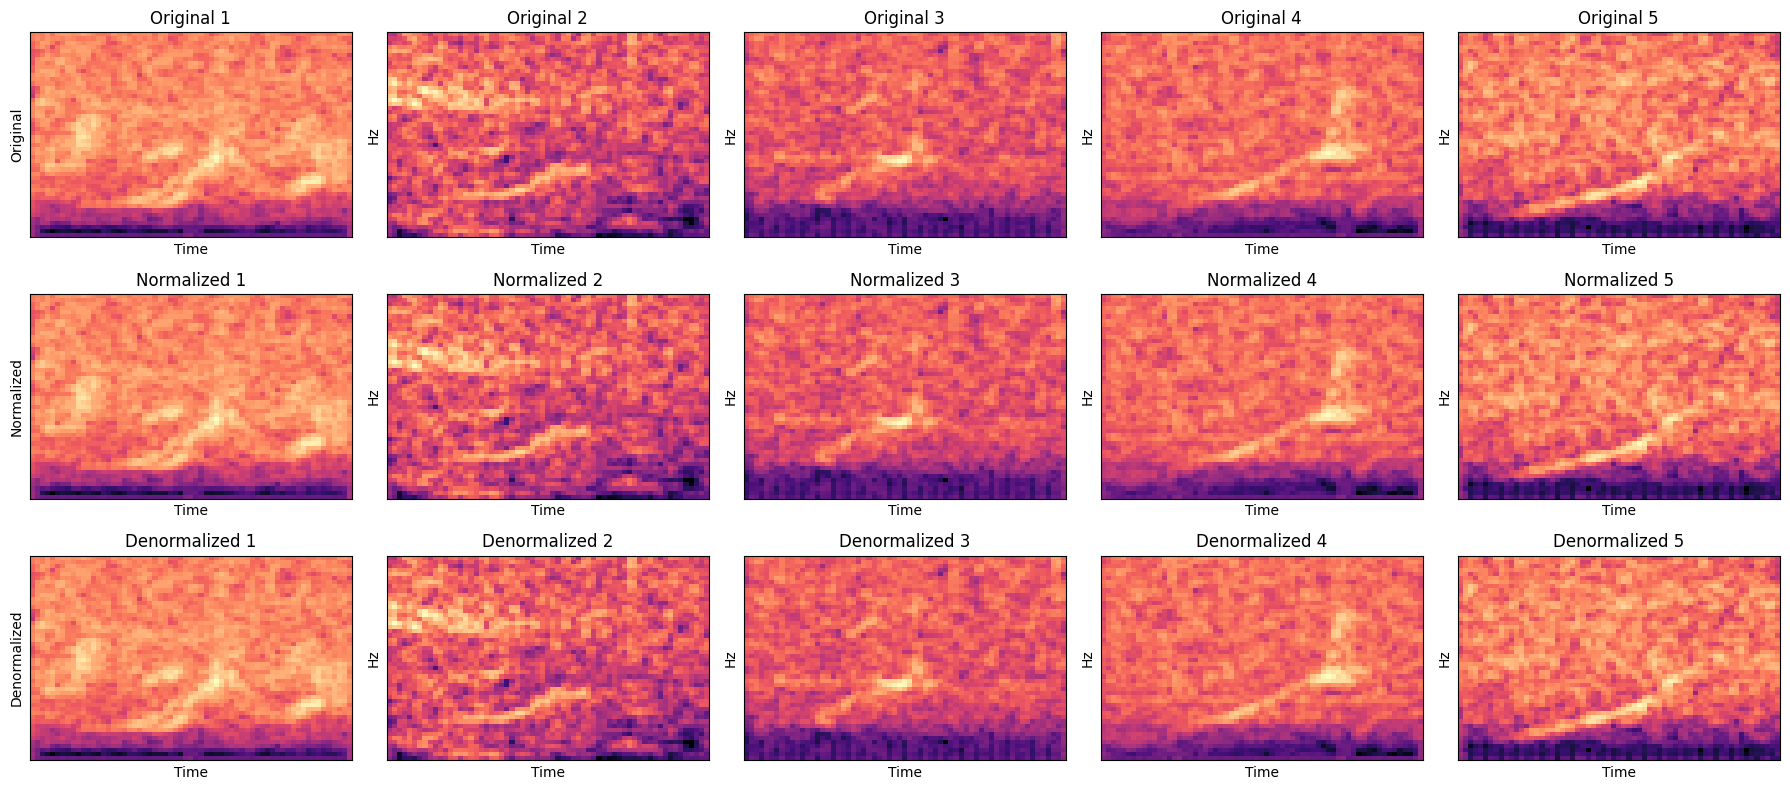

[[-33.229214 -35.363136 -46.20211  ... -38.63774  -44.521477 -44.579636]
 [-31.770987 -35.984596 -47.616127 ... -45.473064 -47.508736 -40.41755 ]
 [-34.700462 -42.51068  -47.163513 ... -44.192818 -45.98033  -42.610966]
 ...
 [-19.653467 -15.755346 -13.980201 ... -19.827393 -22.101805 -26.595238]
 [-20.521988 -16.33151  -13.673588 ... -15.751568 -22.518305 -23.939087]
 [-17.511944 -17.097256 -12.49578  ... -15.380874 -18.713755 -22.989847]]
[[0.58463484 0.5579608  0.4224736  ... 0.5170282  0.44348153 0.44275457]
 [0.60286266 0.55019253 0.40479842 ... 0.43158668 0.4061408  0.49478063]
 [0.56624424 0.4686165  0.4104561  ... 0.44758978 0.42524585 0.46736294]
 ...
 [0.7543317  0.80305815 0.82524747 ... 0.75215757 0.7237274  0.6675595 ]
 [0.74347514 0.7958561  0.8290802  ... 0.80310535 0.71852124 0.70076144]
 [0.7811007  0.7862843  0.84380275 ... 0.8077391  0.7660781  0.71262693]]
[[-33.229214 -35.363136 -46.20211  ... -38.63774  -44.521477 -44.579636]
 [-31.770988 -35.984596 -47.616127 ... 

In [ ]:
# EXPERIMENTO [ NO BORRAR ]

# Preparo los espectrogramas para enchufarselos al vae
#   - grafico 5 muestras pre y post normalizar
print(audio_df)

original_spec_samples = []
normalized_samples = []
denormalized_samples = []
 
global_min, global_max = compute_global_min_max(audio_df)

whale_audio_samples = audio_df[audio_df['label'] == 1].sample(5)['audio']

for sample in whale_audio_samples:
    mel_spec = get_melspectrogram(sample)
    original_spec_samples.append(mel_spec)

    normalized_mel_spec = normalize_spectrogram(mel_spec, global_min, global_max)
    normalized_samples.append(normalized_mel_spec)

    denormalized_mel_spec = denormalize_spectrogram(normalized_mel_spec, global_min, global_max)
    denormalized_samples.append(denormalized_mel_spec)

fig, axes = plt.subplots(3, 5, figsize=(18, 8))

for i in range(5):
    # Original spectrogram
    img0 = librosa.display.specshow(original_spec_samples[i], sr=SR, hop_length=HOP_LENGTH, ax=axes[0, i], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
    axes[0, i].set_title(f'Original {i+1}')
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])

    # Normalized spectrogram
    img1 = librosa.display.specshow(normalized_samples[i], sr=SR, hop_length=HOP_LENGTH, ax=axes[1, i], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
    axes[1, i].set_title(f'Normalized {i+1}')
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])

    # Denormalized spectrogram
    img2 = librosa.display.specshow(denormalized_samples[i], sr=SR, hop_length=HOP_LENGTH, ax=axes[2, i], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
    axes[2, i].set_title(f'Denormalized {i+1}')
    axes[2, i].set_xticks([])
    axes[2, i].set_yticks([])

axes[0, 0].set_ylabel('Original')
axes[1, 0].set_ylabel('Normalized')
axes[2, 0].set_ylabel('Denormalized')
plt.tight_layout()
plt.show()

print(original_spec_samples[-1])
print(normalized_samples[-1])
print(denormalized_samples[-1])



In [132]:
# PASO TODOS LOS AUDIOS A UN ESPECTROGRAMA Y NORMALIZO

mel_specs = []
for whale_audio in audio_df[audio_df['label'] == 1]['audio']:
    mel = get_melspectrogram(whale_audio)
    mel_norm = normalize_spectrogram(mel, global_min, global_max)
    mel_specs.append(mel_norm.flatten())
X = np.array(mel_specs)

In [133]:
# PREPARO LOS DATOS PARA ENCHUFARSELOS AL VAE

X = np.array(mel_specs)  # shape: (num_samples, N_MELS * time_steps)
X_tensor = torch.tensor(X, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(X_tensor), batch_size=128, shuffle=True)

In [ ]:
# VARIATIONAL AUTOENCODER MODEL

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

    def loss(self, x, x_hat, mu, logvar):
        recon_loss = nn.functional.mse_loss(x_hat, x, reduction='mean')
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_div
    
    

In [ ]:
# TRAIN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(X.shape[1], latent_dim=32).to(device)  # Use all data, not X_train
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

epochs = 50
for epoch in range(epochs):
    vae.train()
    total_loss = 0
    for xb_tuple in train_loader:  # xb_tuple is a tuple (xb,)
        xb = xb_tuple[0].to(device)
        x_hat, mu, logvar = vae(xb)
        loss = vae.loss(xb, x_hat, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)  # accumulate per sample
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/50, Loss: 10.9052
Epoch 2/50, Loss: 0.0945
Epoch 3/50, Loss: 0.0470
Epoch 4/50, Loss: 0.0434
Epoch 5/50, Loss: 0.0400
Epoch 6/50, Loss: 0.0357
Epoch 7/50, Loss: 0.0313
Epoch 8/50, Loss: 0.0271
Epoch 9/50, Loss: 0.0232
Epoch 10/50, Loss: 0.0219
Epoch 11/50, Loss: 0.0202
Epoch 12/50, Loss: 0.0178
Epoch 13/50, Loss: 0.0161
Epoch 14/50, Loss: 0.0150
Epoch 15/50, Loss: 0.0147
Epoch 16/50, Loss: 0.0153
Epoch 17/50, Loss: 0.0131
Epoch 18/50, Loss: 0.0125
Epoch 19/50, Loss: 0.0124
Epoch 20/50, Loss: 0.0120
Epoch 21/50, Loss: 0.0120
Epoch 22/50, Loss: 0.0116
Epoch 23/50, Loss: 0.0115
Epoch 24/50, Loss: 0.0111
Epoch 25/50, Loss: 0.0111
Epoch 26/50, Loss: 0.0112
Epoch 27/50, Loss: 0.0112
Epoch 28/50, Loss: 0.0109
Epoch 29/50, Loss: 0.0106
Epoch 30/50, Loss: 0.0108
Epoch 31/50, Loss: 0.0110
Epoch 32/50, Loss: 0.0107
Epoch 33/50, Loss: 0.0107
Epoch 34/50, Loss: 0.0105
Epoch 35/50, Loss: 0.0107
Epoch 36/50, Loss: 0.0105
Epoch 37/50, Loss: 0.0105
Epoch 38/50, Loss: 0.0110
Epoch 39/50, Loss: 0

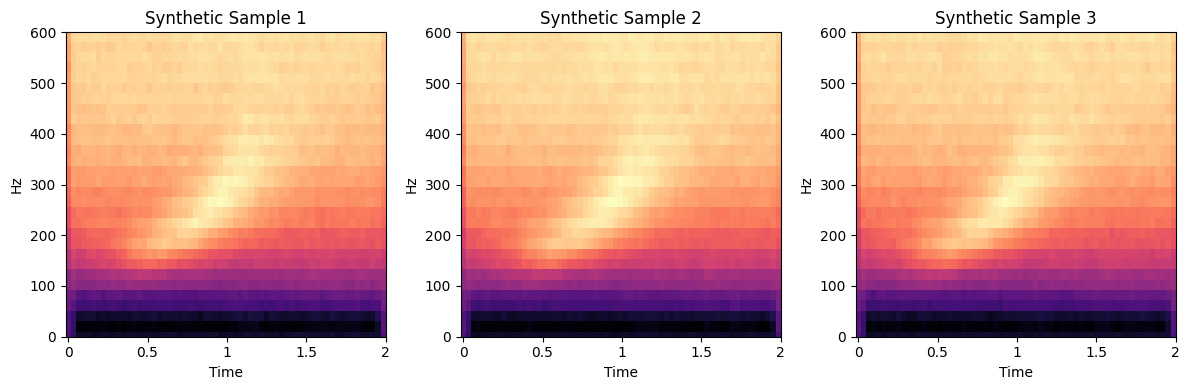

In [143]:
# GENERO MUESTRAS SINTÉTICAS

vae.eval()
num_samples = 3
latent_dim = 32  # Must match your VAE's latent_dim

with torch.no_grad():
    z = torch.randn(num_samples, latent_dim).to(device)
    generated = vae.decode(z).cpu().numpy()

fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))

for i in range(num_samples):
    # Reshape to (N_MELS, time_steps)
    spec_norm = generated[i].reshape((N_MELS, -1))
    # Denormalize
    spec = denormalize_spectrogram(spec_norm, global_min, global_max)
    librosa.display.specshow(spec, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='hz', cmap='magma', ax=axes[i], fmax=MAX_FREQ)
    axes[i].set_title(f"Synthetic Sample {i+1}")
    axes[i].set_ylim([0, MAX_FREQ])

plt.tight_layout()
plt.show()

In [ ]:
# BÚSQUEDA DE HIPERPARÁMETROS

from sklearn.model_selection import KFold, ParameterGrid

def train_vae(X, latent_dim, lr, epochs, batch_size, device):
    vae = VAE(X.shape[1], latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(vae.parameters(), lr=lr)
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    vae.train()
    for epoch in range(epochs):
        for xb_tuple in loader:
            xb = xb_tuple[0].to(device)
            x_hat, mu, logvar = vae(xb)
            loss = vae.loss(xb, x_hat, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return vae

def evaluate_vae(vae, X, device):
    vae.eval()
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=128)
    total_loss = 0
    with torch.no_grad():
        for xb_tuple in loader:
            xb = xb_tuple[0].to(device)
            x_hat, mu, logvar = vae(xb)
            loss = vae.loss(xb, x_hat, mu, logvar)
            total_loss += loss.item() * xb.size(0)
    return total_loss / len(dataset)

# Example grid
param_grid = {
    'latent_dim': [8, 16, 32],
    'lr': [1e-3, 5e-4],
    'epochs': [20, 40],
    'batch_size': [64]
}

kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
results = []

for params in ParameterGrid(param_grid):
    val_losses = []
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        vae = train_vae(X_train, **params, device=device)
        val_loss = evaluate_vae(vae, X_val, device=device)
        val_losses.append(val_loss)
    avg_loss = np.mean(val_losses)
    print(f"Params: {params}, Avg Val Loss: {avg_loss:.4f}")
    results.append((params, avg_loss))

# Find best params
best_params = min(results, key=lambda x: x[1])
print("Best params:", best_params[0])



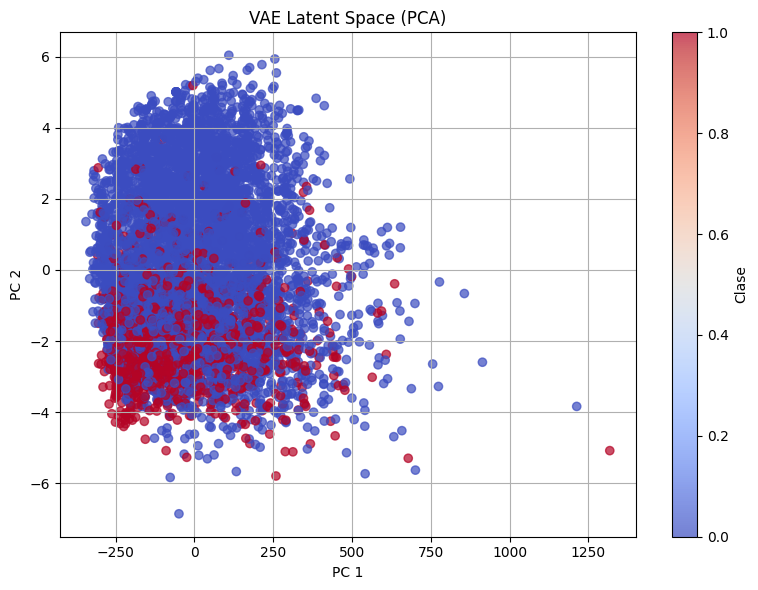

In [136]:
# --------------------------
# Visualización con PCA
# --------------------------
vae.eval()
all_mu = []
all_labels = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        mu, _ = vae.encode(xb)
        all_mu.append(mu.cpu().numpy())
        all_labels.append(yb.numpy())

all_mu = np.concatenate(all_mu, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

pca = PCA(n_components=2)
z_pca = pca.fit_transform(all_mu)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=all_labels, cmap='coolwarm', alpha=0.7)
plt.title("VAE Latent Space (PCA)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(scatter, label="Clase")
plt.grid(True)
plt.tight_layout()
plt.show()

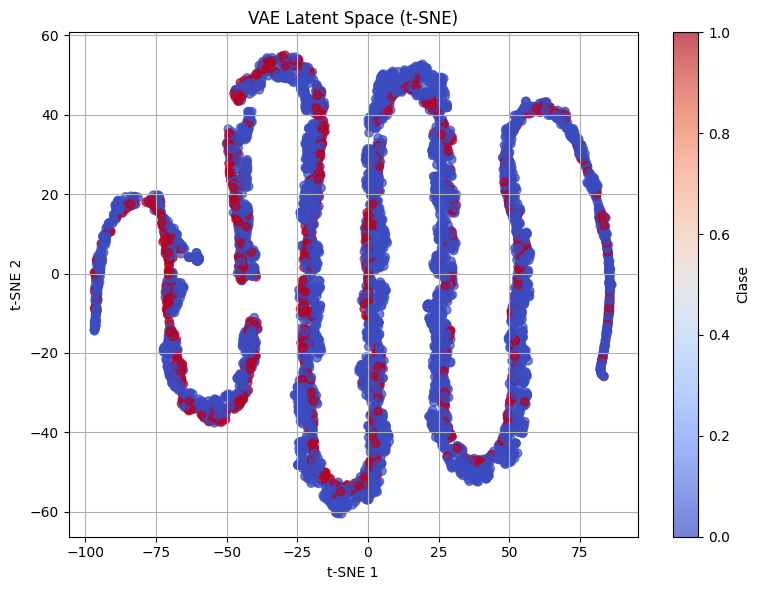

In [137]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=SEED)
z_tsne = tsne.fit_transform(all_mu)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=all_labels, cmap='coolwarm', alpha=0.7)
plt.title("VAE Latent Space (t-SNE)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter, label="Clase")
plt.grid(True)
plt.tight_layout()
plt.show()

In [138]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(all_mu)

ari = adjusted_rand_score(all_labels, cluster_labels)
print(f"Adjusted Rand Index (KMeans): {ari:.4f}")




Adjusted Rand Index (KMeans): -0.0065
